In [17]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

In [28]:
def str_wt_stp_3(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
        elif position == 'long':
            if closing_prices[i] > upper_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < lower_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
    return profit_ts, buy_signal, sell_signal



def strategy_profit_with_stop_loss(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
    return profit_ts, buy_signal, sell_signal


In [19]:
# ===============================================================================================
def func_of_arima_1_1_1(t_1_data, t_2_data, ar_param, ma_param, prev_residual):
    """
    Calculate the ARIMA(1,1,1) value based on previous data and parameters.
    
    :param t_1_data: Previous time series data point (t-1)
    :param t_2_data: Previous time series data point (t-2)
    :param ar_param: AR parameter
    :param ma_param: MA parameter
    :param prev_residual: Previous residual
    :return: Computed value for the current time step
    """
    return ar_param * (t_1_data - t_2_data) + ma_param * prev_residual + t_1_data

def func_of_garch_1_1(omega, alpha, beta, prev_volatility, prev_residual):
    """
    Calculate the GARCH(1,1) value based on previous volatility and residuals.
    :param omega: Constant term
    :param alpha: Coefficient for lagged squared residuals
    :param beta: Coefficient for lagged volatility
    :param prev_volatility: Previous volatility
    :param prev_residual: Previous residual
    :return: Computed volatility for the current time step
    """
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)

def forecast_closing_prices_for_training(df,steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01",
                            order_arima=(1, 1, 1), order_garch=(1, 1) ):
    df_filtered = df.loc[startdate:end_date]
    df_prediction = df.loc[df.index > end_date]


    arima_model = ARIMA(df_filtered['close_scaled_down'], order=order_arima)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        arima_fit = arima_model.fit()
    residual_np = np.array(arima_fit.resid)
    

    garch_model = arch_model(residual_np, vol='Garch', p=order_garch[0], q=order_garch[1])
    garch_fit = garch_model.fit(disp="off")

    ma_param = arima_fit.maparams[0]
    ar_param = arima_fit.arparams[0]

    prediction_arima = []
    residual_prediction = []    
    for i in range(375,len(df_filtered['close_scaled_down'])):
        prediction_arima.append(func_of_arima_1_1_1(
            df_filtered['close_scaled_down'].iloc[i-1],
            df_filtered['close_scaled_down'].iloc[i-2],
            ar_param,
            ma_param,
            residual_np[i-1]
        ))
    prediction_arima.append(func_of_arima_1_1_1(
        df_filtered['close_scaled_down'].iloc[-1],
        df_filtered['close_scaled_down'].iloc[-2],
        ar_param,
        ma_param,
        residual_np[-1]
    ))

    residual_prediction.append(df_prediction['close_scaled_down'][0] - prediction_arima[-1])

    prediction_arima.append(func_of_arima_1_1_1(
        prediction_arima[-1],
        df_filtered['close_scaled_down'].iloc[-1],
        ar_param,
        ma_param,
        residual_prediction[-1]
    ))
    residual_prediction.append(df_prediction['close_scaled_down'][1] - prediction_arima[-1])
    for i in range(2, steps):
        prediction_arima.append(func_of_arima_1_1_1(
            prediction_arima[-1],
            prediction_arima[-2],
            ar_param,
            ma_param,
            residual_prediction[-1]
        ))
        residual_prediction.append(df_prediction['close_scaled_down'][i] - prediction_arima[-1])

    garch_params = garch_fit.params
    omega = garch_params['omega']
    alpha = garch_params['alpha[1]']
    beta = garch_params['beta[1]']

    vol_garch = garch_fit.conditional_volatility
    volatility_prediction = vol_garch.tolist()[375:]

    volatility_prediction.append(func_of_garch_1_1(
        omega,
        alpha,
        beta,
        vol_garch[-1],
        residual_np[-1]
    ))

    for i in range(1, steps):
        volatility_prediction.append(func_of_garch_1_1(
            omega,
            alpha,
            beta,
            volatility_prediction[-1],
            residual_prediction[i-1]
        ))

    return arima_fit, garch_fit, prediction_arima, residual_prediction, volatility_prediction


In [20]:

list_of_period = [5,10,15,20,25,30]
list_of_k = [1,1.5,2]
period = 20
k = 2


# # # Read the data from the Excel file
# xls_file = '/home/vishi/bolinger/OHLC_New.xls'
# xls = xlrd.open_workbook(xls_file)
# sheet = xls.sheet_by_index(0)
# # the sheet is like this 
# # DateTime	open	high	low	close
# # 20241231~09:16:00	2355950	2356430	2354005	2355135

# df = pd.read_excel(xls_file, sheet_name=0, usecols="A:E", header=0)
# # Convert the DateTime column to datetime format
# df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d~%H:%M:%S')
# df["close_scaled_down"] = df["close"] / 1000


In [21]:
# save it in csv file
# df.to_csv('/home/vishi/bolinger/OHLC_New.csv', index=False)

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipykernel_2859/1119086490.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

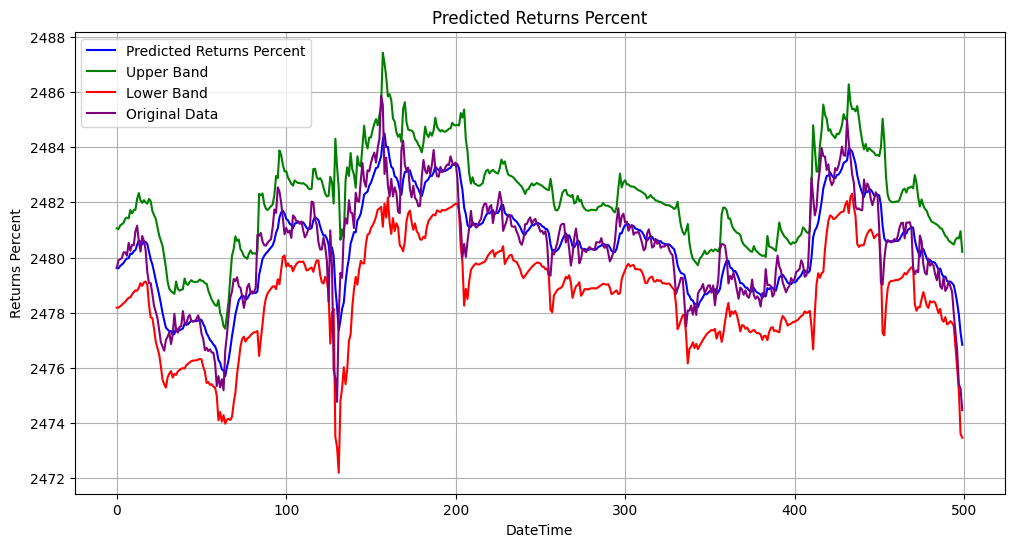

In [25]:
# read the csv file
df = pd.read_csv('/home/vishi/bolinger/OHLC_New.csv', parse_dates=['DateTime'], index_col='DateTime')
df.index = pd.to_datetime(df.index)

arima_fit_forecast, garch_fit_forecast, prediction_arima, residual_prediction, volatility_prediction = forecast_closing_prices_for_training(
    df, steps=20250, startdate="2024-12-31", end_date="2025-03-28 23:00",
    order_arima=(1, 1, 1), order_garch=(1, 1)
)
upper_band = np.array(prediction_arima) + 2 * np.array(volatility_prediction)
lower_band = np.array(prediction_arima) - 2 * np.array(volatility_prediction)
mid_band = np.array(prediction_arima)


plt.figure(figsize=(12, 6))
plt.plot(mid_band[-500:], label='Predicted Returns Percent', color='blue')
plt.plot(upper_band[-500:], label='Upper Band', color='green')
plt.plot(lower_band[-500:], label='Lower Band', color='red')
# plt.plot(resid_pred_xyz, label='Residuals of Predicted Returns Percent', color='orange')
plt.plot(np.array(df['close_scaled_down'].loc['2025-01-01 09:00' : '2025-06-19 23:00'])[-500:], label='Original Data', color='purple')
plt.title('Predicted Returns Percent')
plt.xlabel('DateTime')
plt.ylabel('Returns Percent')
plt.legend()
plt.grid()
plt.show()





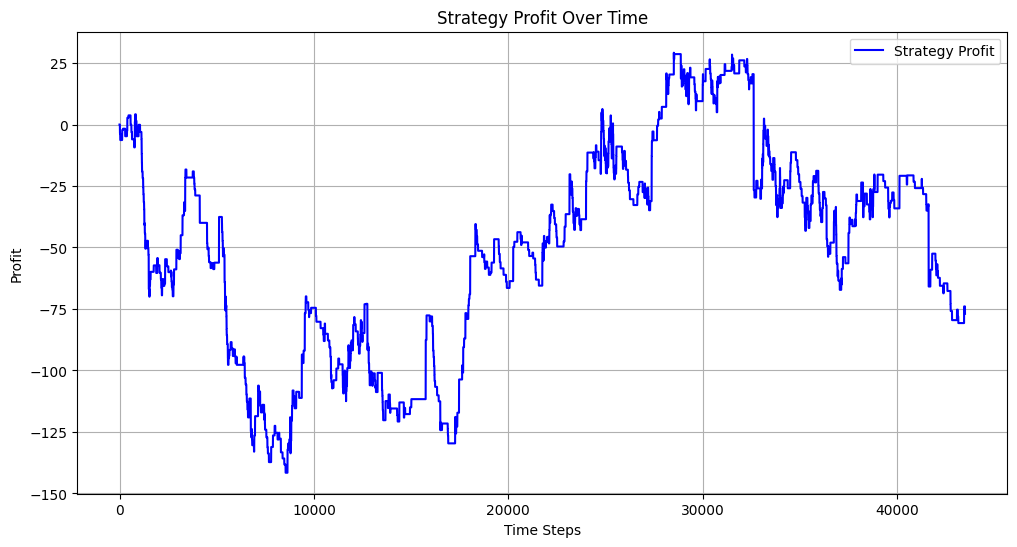

In [26]:
profit_ts, buy_signal, sell_signal = str_wt_stp_3(
    np.array(df['close_scaled_down'].loc['2025-01-01 09:00' : '2025-06-19 23:00'])
    , mid_band, lower_band, upper_band, stop_loss=0.1)
plt.figure(figsize=(12, 6))
plt.plot(profit_ts, label='Strategy Profit', color='blue')

plt.legend()
plt.title('Strategy Profit Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()

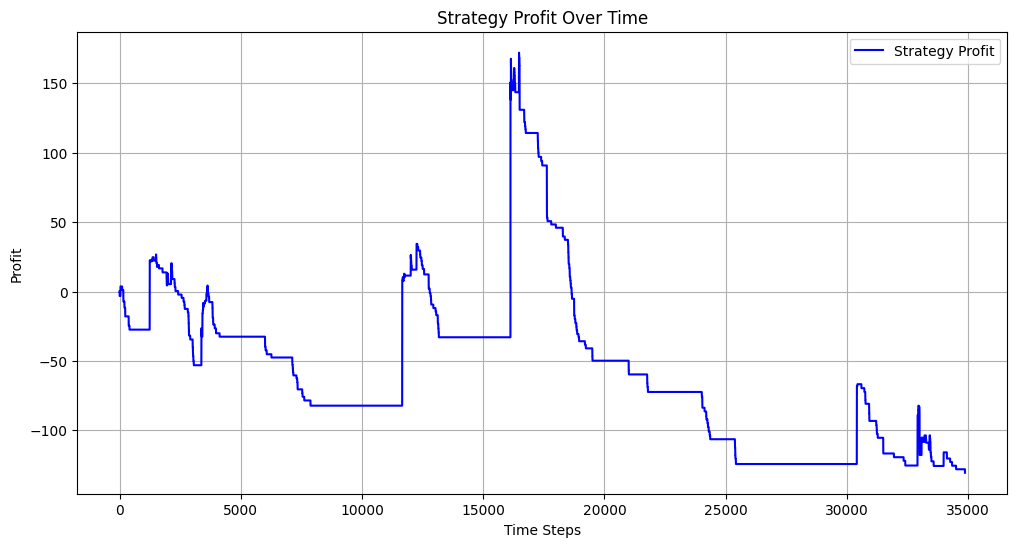

In [29]:
profit_ts, buy_signal, sell_signal = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-06-19 23:00'])
    , mid_band, lower_band, upper_band, stop_loss=0.1)
plt.figure(figsize=(12, 6))
plt.plot(profit_ts, label='Strategy Profit', color='blue')

plt.legend()
plt.title('Strategy Profit Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()


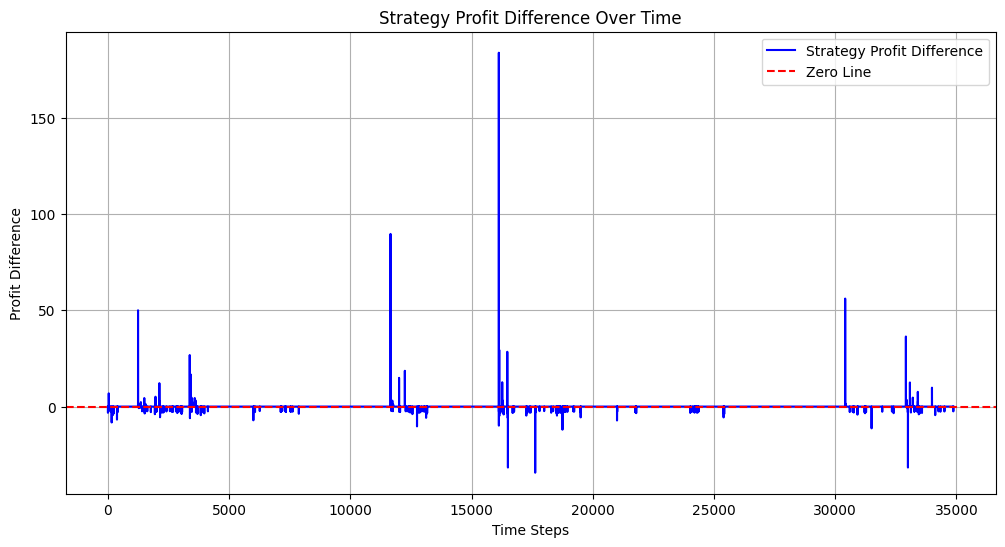

In [30]:
profit_ts_diff = np.diff(profit_ts)
plt.figure(figsize=(12, 6))

plt.plot(profit_ts_diff, label='Strategy Profit Difference', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.title('Strategy Profit Difference Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit Difference')
plt.grid()
plt.show()